In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from sklearn import model_selection

import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Function to show images
def show_images(df, y):
    n_rows, n_cols = 3, 7
    plt.figure(figsize=(15,9))
    for i in range(n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(df[i])
        plt.title('Label: {}'.format(y[i]))
    plt.show()

Shapes of data before reshaping:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


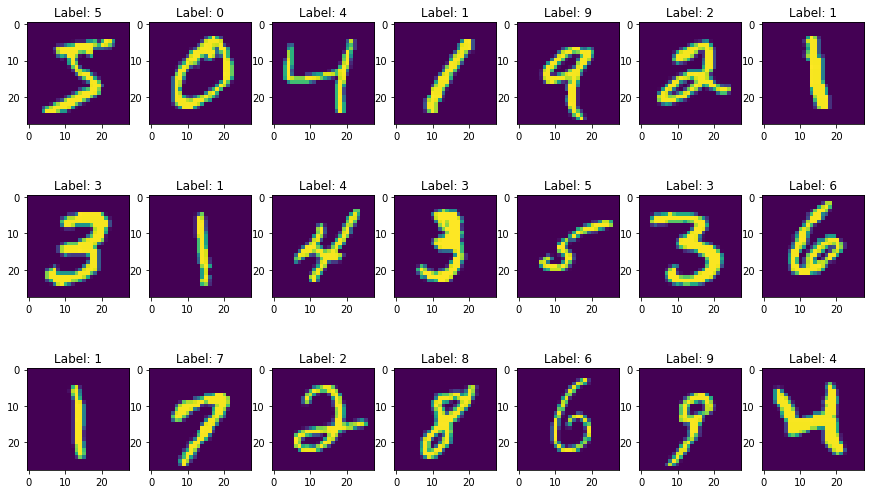

Shapes of data after reshaping:  (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [3]:
# Function to load dataset from keras
def load_dataset(show_some_images = False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    print('Shapes of data before reshaping: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    if show_some_images: show_images(X_train, y_train)
    # Reshaping dataset to have a single channel
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = X_train/255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test/255.0
    
    # One hot encoding for target values (each encoding for each target value)
    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    print('Shapes of data after reshaping: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(True)

In [4]:
# Evaluate the model using KFold cross validation
def evaluate_model(X_data, y_data, n_epochs, batch_size, n_folds=5):
    scores, histories = list(), list()
    # Prepare cross validation
    kfold = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    # Enumerate splits
    i = 1
    for train_ix, test_ix in kfold.split(X_data):
        print('Round {} of {}'.format(i, n_folds))
        i += 1
        # define model
        model = build_model()
        # Select rows for train & test
        train_X, train_y, test_X, test_y = X_data[train_ix], y_data[train_ix], X_data[test_ix], y_data[test_ix]
        # Fit model
        history = model.fit(train_X, train_y, 
                            epochs=n_epochs, 
                            batch_size=batch_size,
                            validation_data=(test_X, test_y),
                            verbose=1)
        # Evaluate model
        # Returns the loss value & metrics values for the model in test mode.
        _, score = model.evaluate(test_X, test_y, verbose=1)
        
        scores.append(score)
        histories.append(history)
    return scores, histories

def summarize_result(histories):
    plt.figure(figsize=(20,6))
    for i in range(len(histories)):
        # Plot Accuracy
        plt.subplot(121)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.legend(['train', 'test'])
        
        # Plot loss
        plt.subplot(122)
        plt.title('Cross entropy loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.legend(['train', 'test'])
    plt.show()
    
# Summarize model performances
def summarize_performance(score):
    print('Metric score: Mean = %.3f, std = %.3f'%(np.mean(score), np.std(score)))
    plt.boxplot(score)
    plt.show()

## NN architecture #1

In [5]:
# Build our model ---> (CNN)
def build_model():
    model = Sequential()
    # First Convolution Layer
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
    # MaxPool layer with 2x2 pool size
    model.add(MaxPooling2D((2, 2)))
    # Flattening the output from Convolution Layers
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(units=128, 
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    # Output a softmax to squash the matrix into output probabilities
    model.add(Dense(units=10, activation='softmax'))
    
    # Compiling model
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
                  loss=keras.losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    return model

build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


Shapes of data before reshaping:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Shapes of data after reshaping:  (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0


375/375 [==============================] - 19s 52ms/step - loss: 0.0570 - accuracy: 0.9830 - val_loss: 0.0674 - val_accuracy: 0.9800
Epoch 3/15
375/375 [==============================] - 19s 52ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.0604 - val_accuracy: 0.9824
Epoch 4/15
375/375 [==============================] - 19s 52ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0592 - val_accuracy: 0.9837
Epoch 5/15
375/375 [==============================] - 20s 52ms/step - loss: 0.0151 - accuracy: 0.9957 - val_loss: 0.0538 - val_accuracy: 0.9847
Epoch 6/15
375/375 [==============================] - 20s 52ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0590 - val_accuracy: 0.9836
Epoch 7/15
375/375 [==============================] - 19s 51ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.0628 - val_accuracy: 0.9830
Epoch 8/15
375/375 [==============================] - 19s 51ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0617 - val_accuracy: 0.9834
Epo

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


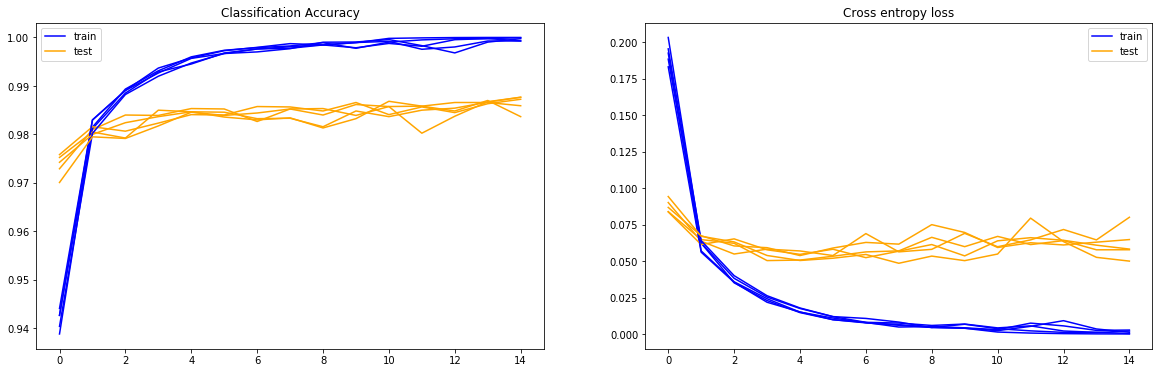

Metric score: Mean = 0.986, std = 0.002


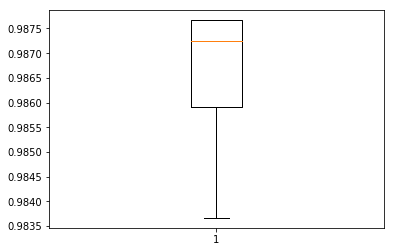

In [6]:
# Constants
SEED = 123
N_FOLDS = 5
N_EPOCHS = 15
BATCH_SIZE = 128

def run_test_harness():
    # Get the data
    X_train, y_train, X_test, y_test = load_dataset()
    print()
    
    # Print model summary
    print(build_model().summary())
    print()
    # Evaluate the model
    scores, histories = evaluate_model(X_train, y_train, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_folds=N_FOLDS)
    
    # Summarize the results
    summarize_result(histories)
    
    # Summarize performce
    summarize_performance(scores)
    
    return scores, histories

scores, histories = run_test_harness()

## NN architecture #2

In [7]:
# Build our model ---> (CNN)
def build_model():
    model = Sequential()
    # First Convolution Layer
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
    # Dropout for convergence
    model.add(Dropout(0.25))
    # MaxPool layer with 2x2 pool size
    model.add(MaxPooling2D((2, 2)))
    # Flattening the output from Convolution Layers
    model.add(Flatten())
    
    model.add(Dense(units=128, 
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    # Again a dropout for convergence
    model.add(Dropout(0.25))
    # Output a softmax to squash the matrix into output probabilities
    model.add(Dense(units=10, activation='softmax'))
    
    # Compiling model
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
                  loss=keras.losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    return model

build_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               692352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

Shapes of data before reshaping:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Shapes of data after reshaping:  (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               692352    
_________________________________________________________________
dropou

375/375 [==============================] - 1s 3ms/step - loss: 0.0492 - accuracy: 0.9863
Round 4 of 5
Epoch 1/15
375/375 [==============================] - 21s 57ms/step - loss: 0.2814 - accuracy: 0.9128 - val_loss: 0.1133 - val_accuracy: 0.9678
Epoch 2/15
375/375 [==============================] - 22s 59ms/step - loss: 0.1051 - accuracy: 0.9680 - val_loss: 0.0744 - val_accuracy: 0.9804
Epoch 3/15
375/375 [==============================] - 23s 62ms/step - loss: 0.0717 - accuracy: 0.9785 - val_loss: 0.0591 - val_accuracy: 0.9833
Epoch 4/15
375/375 [==============================] - 22s 59ms/step - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.0560 - val_accuracy: 0.9827
Epoch 5/15
375/375 [==============================] - 22s 58ms/step - loss: 0.0429 - accuracy: 0.9858 - val_loss: 0.0505 - val_accuracy: 0.9859
Epoch 6/15
375/375 [==============================] - 22s 58ms/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0498 - val_accuracy: 0.9847
Epoch 7/15
375/375 [==============

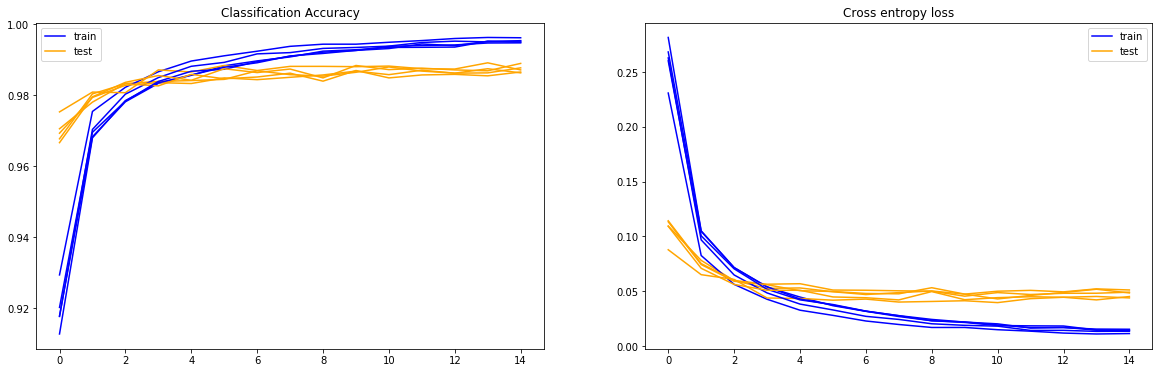

Metric score: Mean = 0.987, std = 0.001


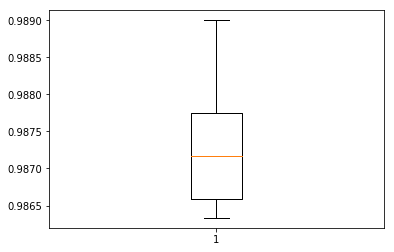

In [8]:
# Constants
SEED = 123
N_FOLDS = 5
N_EPOCHS = 15
BATCH_SIZE = 128

def run_test_harness():
    # Get the data
    X_train, y_train, X_test, y_test = load_dataset()
    print()
    
    # Print model summary
    print(build_model().summary())
    print()
    # Evaluate the model
    scores, histories = evaluate_model(X_train, y_train, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_folds=N_FOLDS)
    
    # Summarize the results
    summarize_result(histories)
    
    # Summarize performce
    summarize_performance(scores)
    
    return scores, histories

scores, histories = run_test_harness()

## NN architecture #3

In [9]:
# Build our model ---> (CNN)
def build_model():
    model = Sequential()
    # First Convolution Layer
    model.add(Conv2D(48, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
    # Dropout for convergence
    model.add(Dropout(0.25))
    # MaxPool layer with 2x2 pool size
    model.add(MaxPooling2D((2, 2)))
    # Flattening the output from Convolution Layers
    model.add(Flatten())
    
    model.add(Dense(units=256, 
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    # Again a dropout for convergence
    model.add(Dropout(0.25))
    # Output a softmax to squash the matrix into output probabilities
    model.add(Dense(units=10, activation='softmax'))
    
    # Compiling model
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
                  loss=keras.losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    return model

build_model().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 48)        480       
_________________________________________________________________
dropout_14 (Dropout)         (None, 26, 26, 48)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 48)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8112)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               2076928   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)              

Shapes of data before reshaping:  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Shapes of data after reshaping:  (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 48)        480       
_________________________________________________________________
dropout_16 (Dropout)         (None, 26, 26, 48)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 48)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8112)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               2076928   
_________________________________________________________________
dropo

375/375 [==============================] - 2s 5ms/step - loss: 0.0445 - accuracy: 0.9880
Round 4 of 5
Epoch 1/15
375/375 [==============================] - 36s 95ms/step - loss: 0.2145 - accuracy: 0.9333 - val_loss: 0.1002 - val_accuracy: 0.9707
Epoch 2/15
375/375 [==============================] - 36s 95ms/step - loss: 0.0737 - accuracy: 0.9777 - val_loss: 0.0620 - val_accuracy: 0.9822
Epoch 3/15
375/375 [==============================] - 36s 95ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.0544 - val_accuracy: 0.9838
Epoch 4/15
375/375 [==============================] - 36s 96ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0487 - val_accuracy: 0.9846
Epoch 5/15
375/375 [==============================] - 36s 95ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0442 - val_accuracy: 0.9871
Epoch 6/15
375/375 [==============================] - 36s 96ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0464 - val_accuracy: 0.9858
Epoch 7/15
375/375 [==============

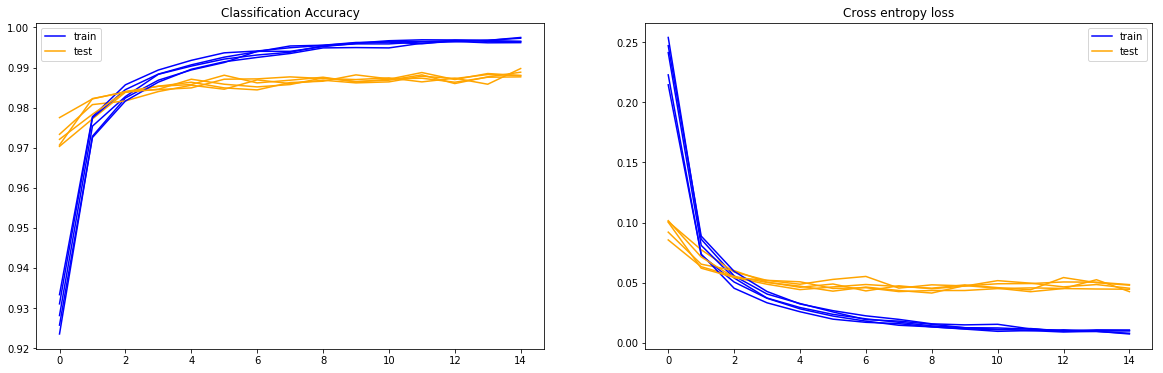

Metric score: Mean = 0.988, std = 0.001


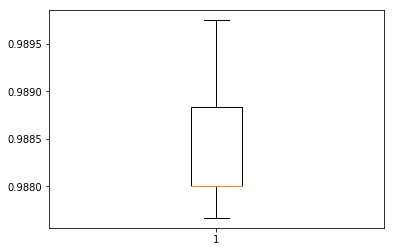

In [10]:
# Constants
SEED = 123
N_FOLDS = 5
N_EPOCHS = 15
BATCH_SIZE = 128

def run_test_harness():
    # Get the data
    X_train, y_train, X_test, y_test = load_dataset()
    print()
    
    # Print model summary
    print(build_model().summary())
    print()
    # Evaluate the model
    scores, histories = evaluate_model(X_train, y_train, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_folds=N_FOLDS)
    
    # Summarize the results
    summarize_result(histories)
    
    # Summarize performce
    summarize_performance(scores)
    
    return scores, histories

scores, histories = run_test_harness()